In [5]:
import os
from cgi import parse_header

from sympy.utilities.magic import pollute

input_dir = '../data/pets/images/'
target_dir = '../data/pets/annotations/trimaps'

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)
                       if fname.endswith('.png') and not fname.startswith('.')])

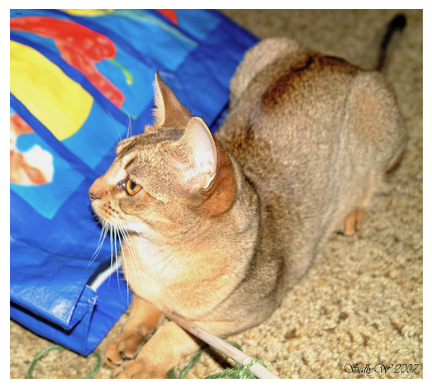

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

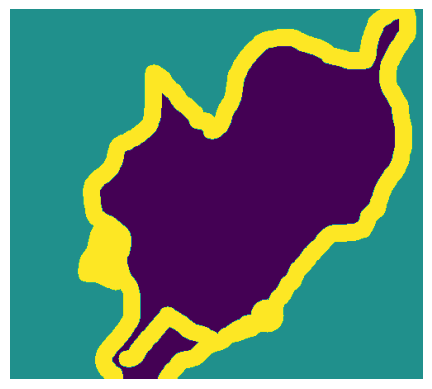

In [7]:
def display_target(target_array):
    normalized_array = (target_array.astype('uint8') - 1) * 127
    plt.axis('off')
    plt.imshow(normalized_array[:, :, 0])


img = img_to_array(load_img(target_paths[9], color_mode='grayscale'))
display_target(img)

In [8]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)


def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))


def path_to_target_image(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype('uint8') - 1
    return img


input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target_image(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [9]:
from tensorflow import keras
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

    model = keras.Model(inputs, outputs)
    return model


model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callbacks = [keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, epochs=50, callbacks=callbacks,
                    batch_size=64, validation_data=(val_input_imgs, val_targets))

Epoch 1/50
  8/100 ━━━━━━━━━━━━━━━━━━━━ 15:46 10s/step - loss: 1.0868

KeyboardInterrupt: 

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model('oxford_segmentation.keras')

i = 4
test_image = val_input_imgs[i]
plt.axis('off')
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]


def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis('off')
    plt.imshow(mask)


display_mask(mask)

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
residual = x
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

In [12]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
residual = x
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [15]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1. / 255)(inputs)


def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding='same')(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x


x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=True)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 32, 32, 3) │          0 │ input_layer_5[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │        896 │ rescaling_3[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │        128 │ rescaling_3[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │     18,496 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_20[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 64)  │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 8, 8, 64)  │          0 │ max_pooling2d_4[… │
│                     │                   │            │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 4, 4, 128) │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 4, 4, 128) │      8,320 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 4, 4, 128) │          0 │ max_pooling2d_5[… │
│                     │                   │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_6[0][0]       │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 피해야 할 배치 정규화
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.BatchNormalization()(x)

ValueError: Input 0 of layer "conv2d_26" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 128)

In [17]:
# 올바른 배치 정규화 사용법
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

ValueError: Input 0 of layer "conv2d_27" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 128)

In [18]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

NameError: name 'data_augmentation' is not defined

In [22]:
from tensorflow import keras

model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

In [23]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(fname='cat.jpg', origin='https://img-datasets.s3.amazonaws.com/cat.jpg')


def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step


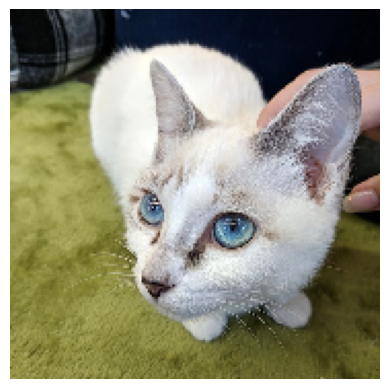

In [24]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [25]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [26]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [27]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


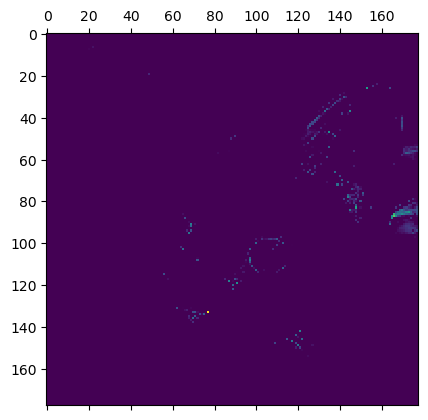

In [28]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

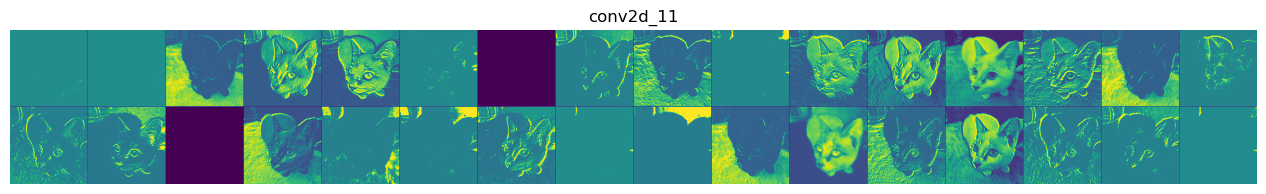

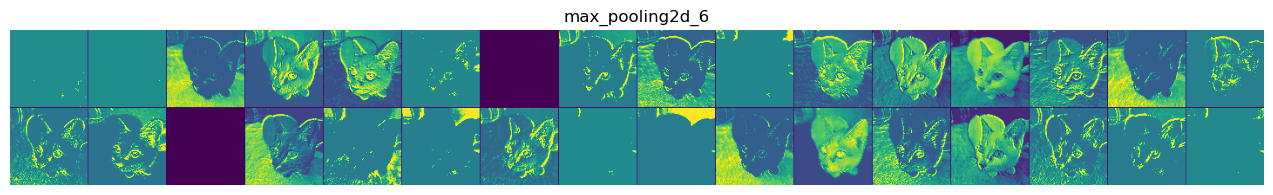

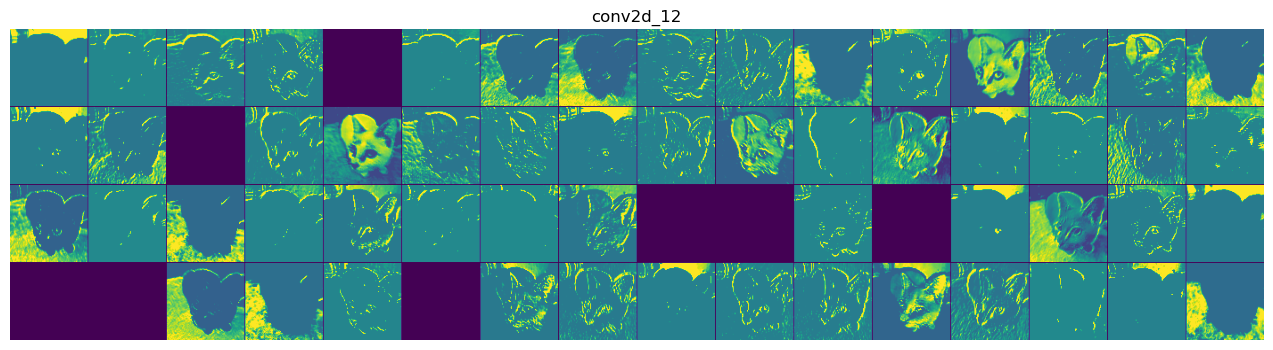

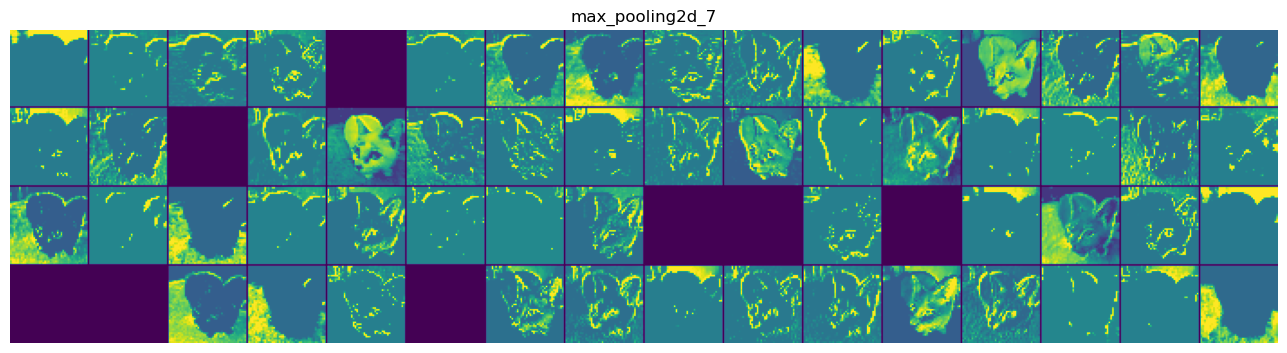

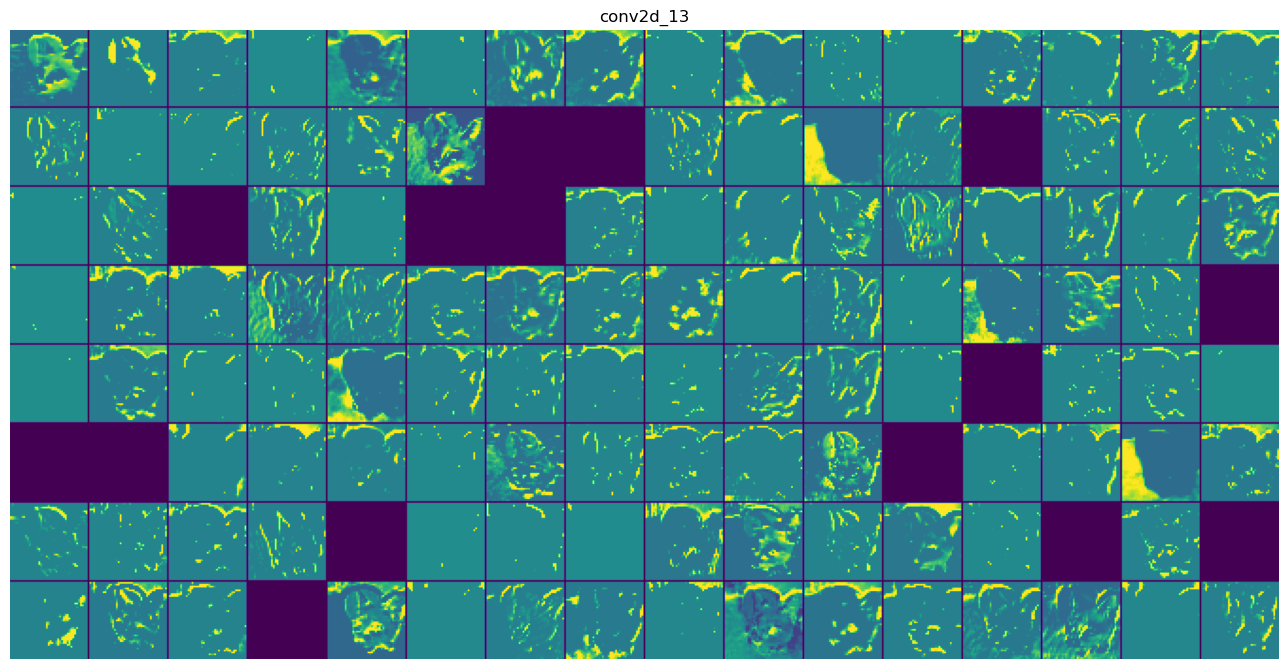

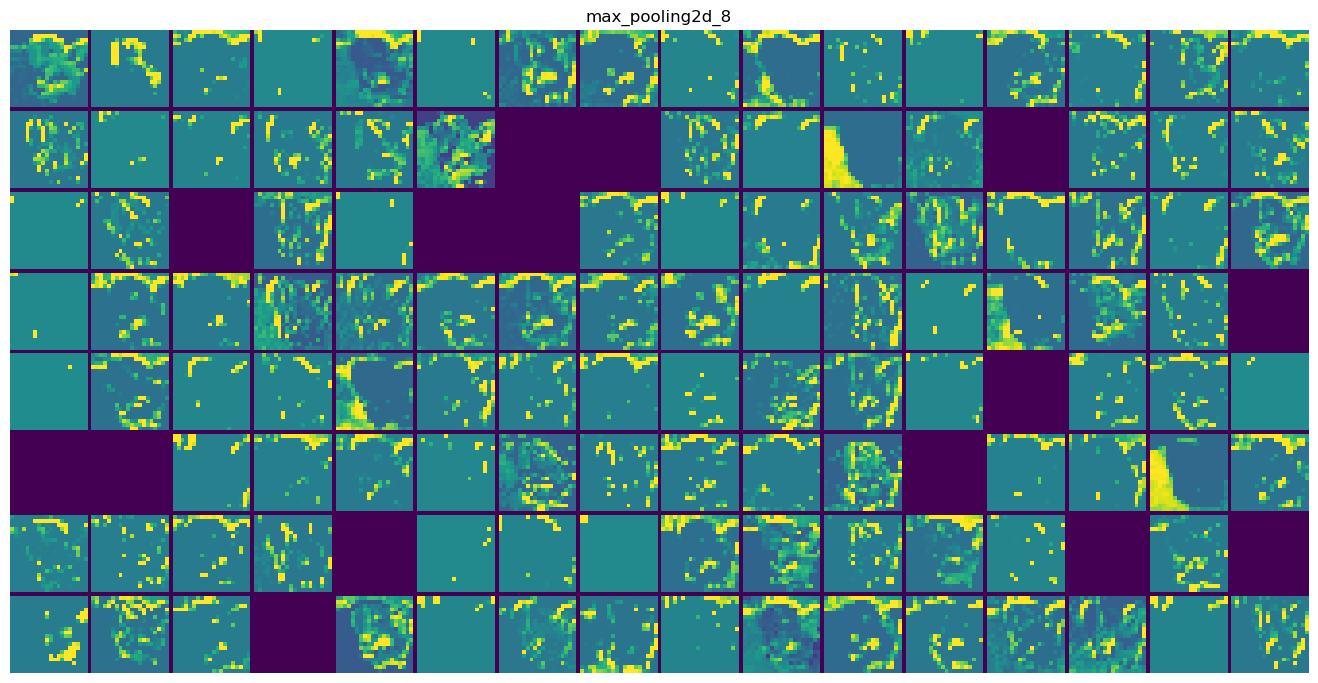

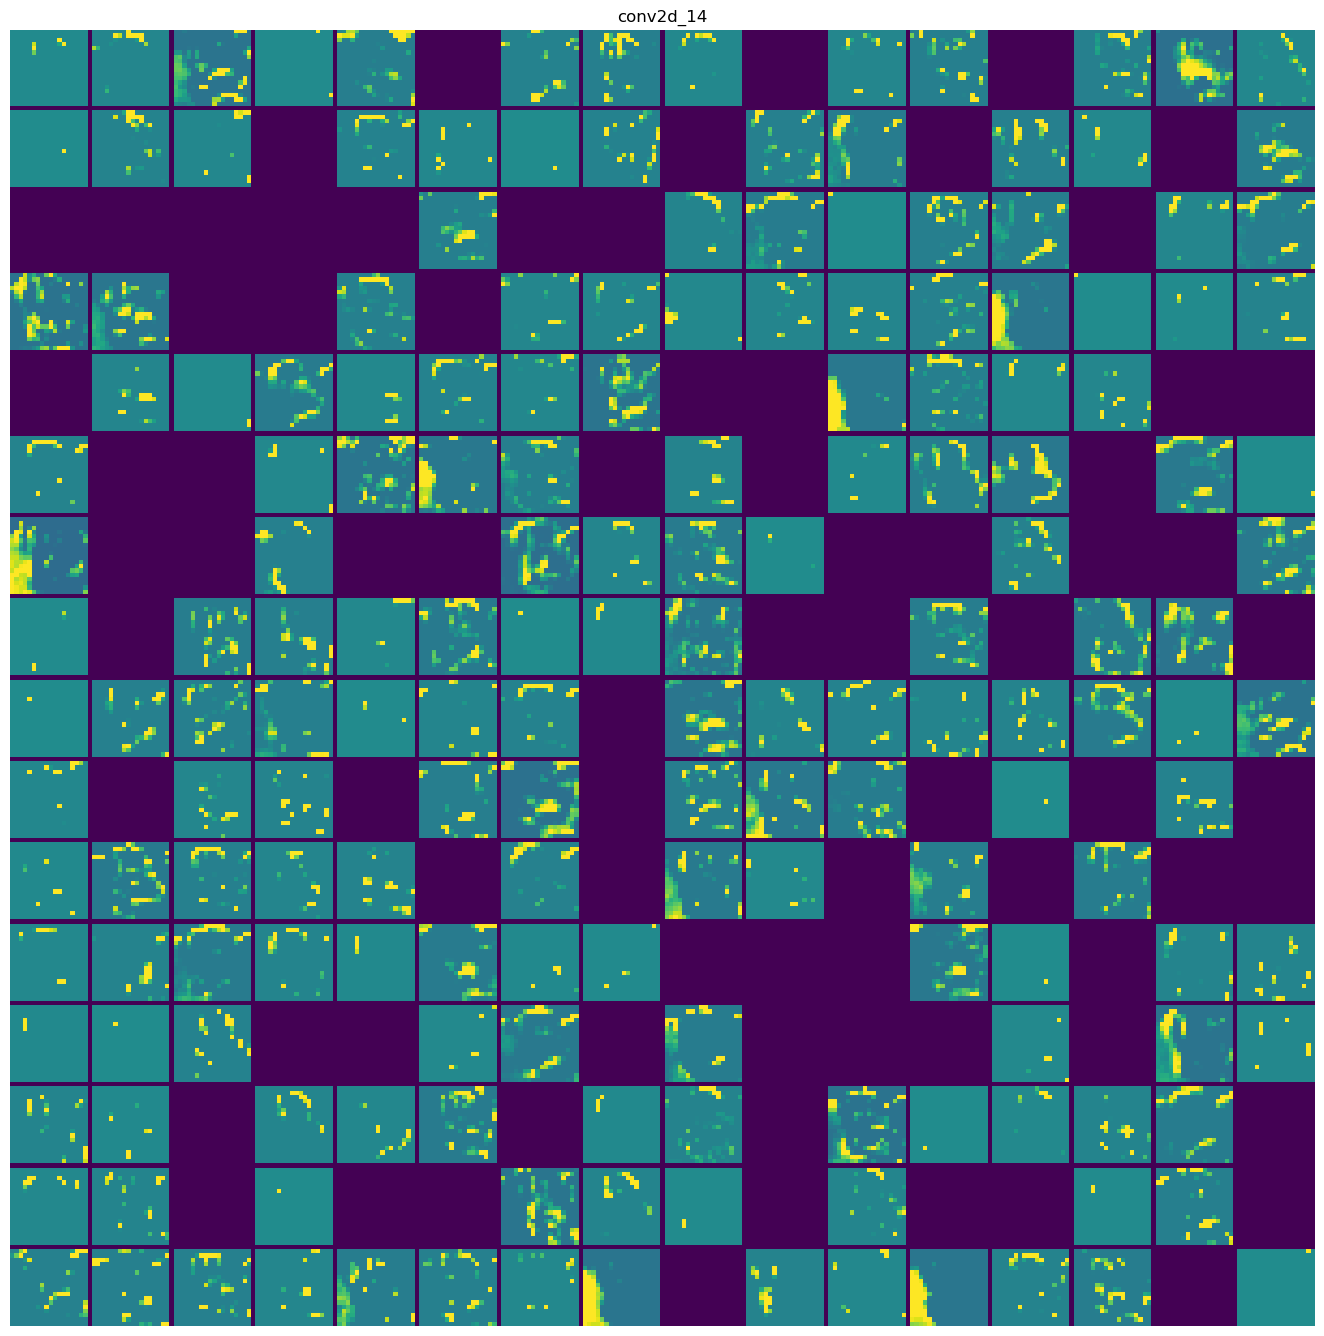

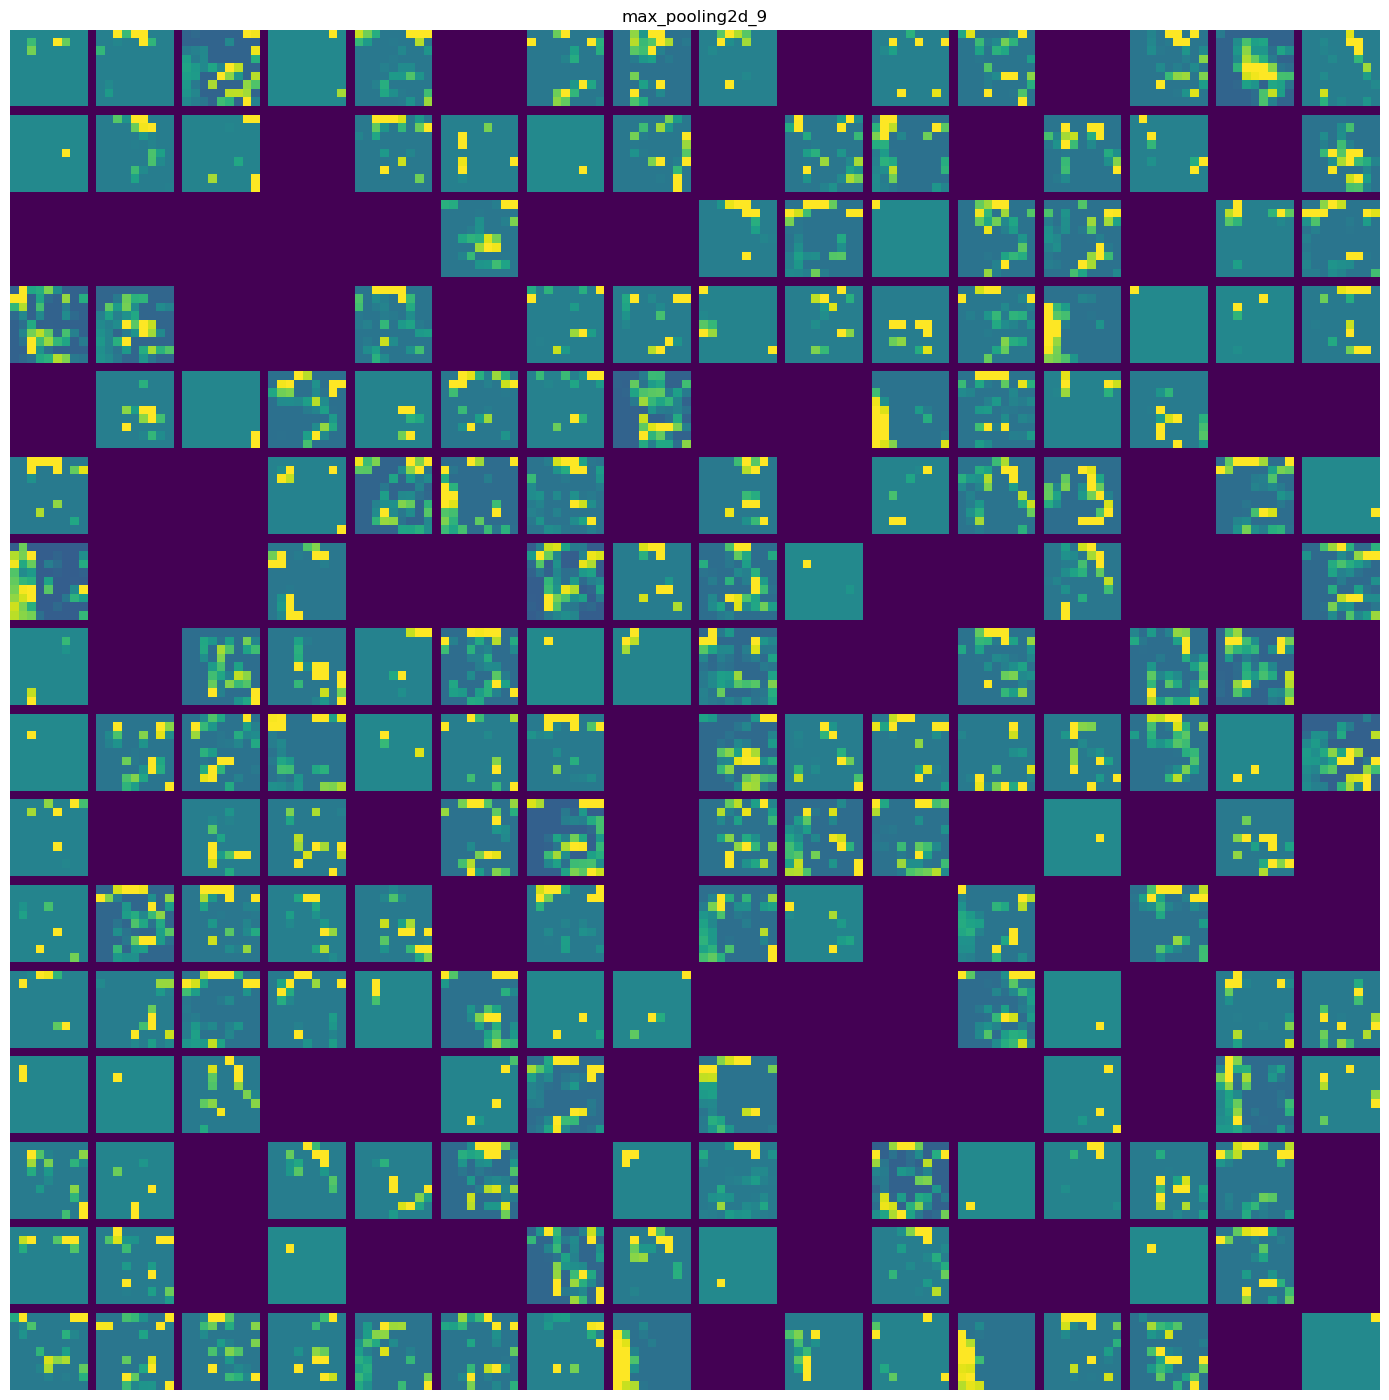

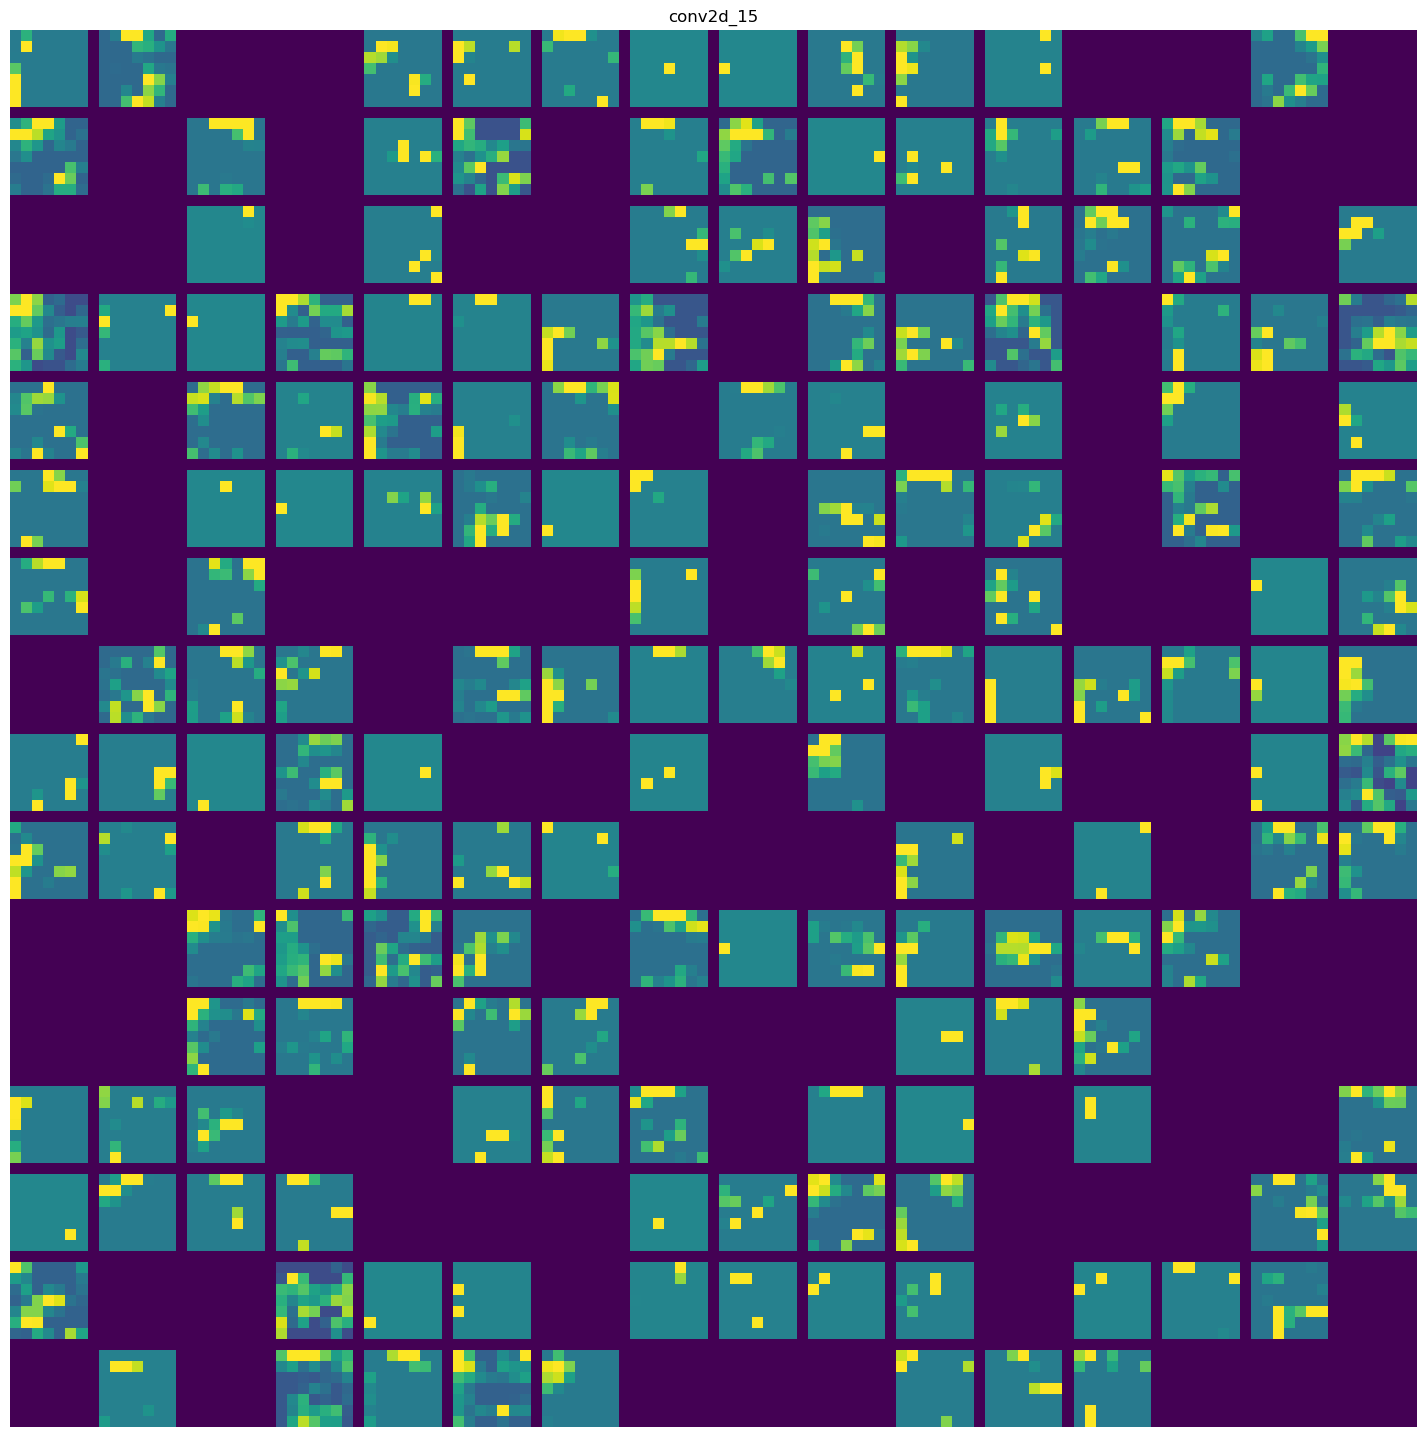

In [29]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * (size + 1): (col + 1) * size + col,
            row * (size + 1): (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [30]:
model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

In [31]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.MaxPooling2D)):
        print(layer.name)

block1_conv1
block1_conv2
conv2d_28
block2_pool
conv2d_29
block3_pool
conv2d_30
block4_pool
conv2d_31
block13_pool


In [32]:
layer_name = 'block3_sepconv1'
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [33]:
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

In [34]:
import tensorflow as tf


def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [35]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [36]:
img_width = 200
img_height = 200


def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [37]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    image = image[25:-25, 25:-25, :]
    return image

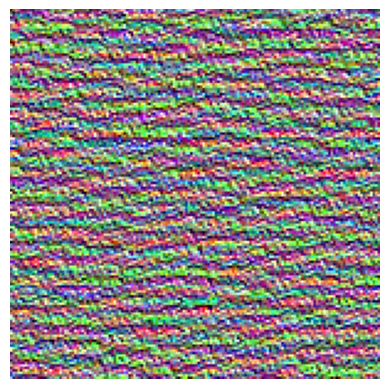

In [38]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

In [39]:
all_images = []
for filter_index in range(64):
    print(f'{filter_index}번 필터 처리중')
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[(cropped_width + margin) * i: (cropped_width + margin) * i + cropped_width,
        (cropped_height + margin) * j: (cropped_height + margin) * j + cropped_height, :,] = image

keras.utils.save_img(f'filters_for_layer_{layer_name}.png', stitched_filters)

0번 필터 처리중
1번 필터 처리중
2번 필터 처리중
3번 필터 처리중
4번 필터 처리중
5번 필터 처리중
6번 필터 처리중
7번 필터 처리중
8번 필터 처리중
9번 필터 처리중
10번 필터 처리중
11번 필터 처리중
12번 필터 처리중
13번 필터 처리중
14번 필터 처리중
15번 필터 처리중
16번 필터 처리중
17번 필터 처리중
18번 필터 처리중
19번 필터 처리중
20번 필터 처리중
21번 필터 처리중
22번 필터 처리중
23번 필터 처리중
24번 필터 처리중
25번 필터 처리중
26번 필터 처리중
27번 필터 처리중
28번 필터 처리중
29번 필터 처리중
30번 필터 처리중
31번 필터 처리중
32번 필터 처리중
33번 필터 처리중
34번 필터 처리중
35번 필터 처리중
36번 필터 처리중
37번 필터 처리중
38번 필터 처리중
39번 필터 처리중
40번 필터 처리중
41번 필터 처리중
42번 필터 처리중
43번 필터 처리중
44번 필터 처리중
45번 필터 처리중
46번 필터 처리중
47번 필터 처리중
48번 필터 처리중
49번 필터 처리중
50번 필터 처리중
51번 필터 처리중
52번 필터 처리중
53번 필터 처리중
54번 필터 처리중
55번 필터 처리중
56번 필터 처리중
57번 필터 처리중
58번 필터 처리중
59번 필터 처리중
60번 필터 처리중
61번 필터 처리중
62번 필터 처리중
63번 필터 처리중


In [40]:
model = keras.applications.xception.Xception(weights='imagenet')

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [41]:
img_path = keras.utils.get_file(fname='elephant.jpg', origin='https://img-datasets.s3.amazonaws.com/elephant.jpg')


def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array


img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [42]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
[('n02504458', 'African_elephant', 0.86992705), ('n01871265', 'tusker', 0.076968506), ('n02504013', 'Indian_elephant', 0.023537192)]


In [43]:
np.argmax(preds[0])

386

In [44]:
last_conv_layer_name = 'block14_sepconv2_act'
classifier_layer_names = ['avg_pool', 'predictions']
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [45]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [46]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [47]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

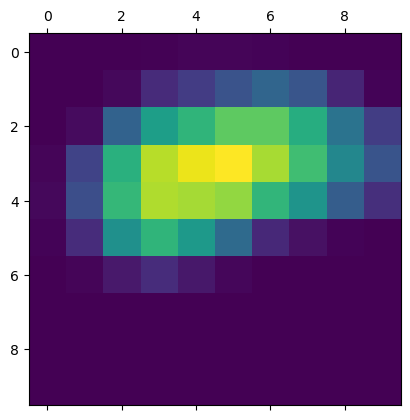

In [48]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [55]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = 'elephant_cam.jpg'
superimposed_img.save(save_path)

/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_7744/467438950.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap(name='jet')
